# Benchmark Optimization Functions Using Genetic Algorithms

## Introduction

This notebook presents the implementation and analysis for the assignment **Benchmark Optimization Functions Using Genetic Algorithms**. The objective of this project is to explore multimodal benchmark functions and apply Genetic Algorithms (GAs) to locate their global minima.

The main goals of this assignment are:
- To select and implement two multimodal functions in Python.
- To visualize these functions using both 2D contour plots and 3D surface plots.
- To optimize each function using a configurable Genetic Algorithm.
- To perform a statistical performance analysis across different GA configurations.

Through this assignment, we gain hands-on experience with optimization techniques and evaluate the impact of genetic operators and parameter tuning on GA performance.

## 1. Function Selection

For this assignment, we selected two multimodal benchmark functions from the [Virtual Library of Simulation Experiments](http://www.sfu.ca/~ssurjano) by Surjanovic & Bingham [1]. Both functions are 2-dimensional and belong to the first set of commonly used optimization test functions.

### **Function 1: Rastrigin Function**

- **Domain**:  
  f₁: [-5.12, 5.12] × [-5.12, 5.12] → ℝ

- **Functional Form (for 2D)**:  
  f₁(x, y) = 20 + x² - 10·cos(2πx) + y² - 10·cos(2πy)

- **Global Minimum**:  
  f₁(0, 0) = 0

- **Characteristics**:  
  Highly multimodal with many regularly spaced local minima, but with a single global minimum at the origin. This function is suitable for evaluating a genetic algorithm’s ability to avoid premature convergence and explore the search space effectively.

In [4]:
def rastrigin(x):
    """
    General n-dimensional Rastrigin function.
    Global minimum at x = (0,...,0) where f(x) = 0.
    Common domain: [-5.12, 5.12]^n
    """
    A = 10
    n = len(x)
    return A * n + sum([xi**2 - A * np.cos(2 * np.pi * xi) for xi in x])

### **Function 2: Ackley Function**

- **Domain**:  
  f₂: [-5, 5] × [-5, 5] → ℝ

- **Functional Form (for 2D)**:  
  f₂(x, y) = -20·exp( -0.2·√(0.5·(x² + y²)) ) - exp( 0.5·(cos(2πx) + cos(2πy)) ) + e + 20

- **Global Minimum**:  
  f₂(0, 0) = 0

- **Characteristics**:  
  Multimodal with many local optima, but features a broad, nearly flat basin surrounding the global minimum. It is commonly used to evaluate an algorithm’s ability to converge efficiently while avoiding local optima traps.

In [6]:
def ackley(x):
    """
    General n-dimensional Ackley function.
    Global minimum at x = (0,...,0) where f(x) = 0.
    Common domain: [-5, 5]^n
    """
    x = np.array(x)
    n = len(x)
    sum_sq_term = -0.2 * np.sqrt(np.sum(x**2) / n)
    cos_term = np.sum(np.cos(2 * np.pi * x)) / n
    return -20 * np.exp(sum_sq_term) - np.exp(cos_term) + 20 + np.e

## 2. Function Implementation and Visualization

### Imports

(Needed for the visualization of the functions)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Function used for visualization

To visualize the selected optimization functions, we use a common Python function that generates both 2D contour plots and 3D surface plots. This function takes as input:

- The function to be plotted
- The domain bounds (as a 4-element list: `[x_min, x_max, y_min, y_max]`)
- A title to label the plots

This approach ensures consistent visual representation for both the Rastrigin and Ackley functions.

This function is used to generate the plots shown next.

In [11]:
def plot_function(func, bounds, title):
    """
    Plots a 2D contour and 3D surface visualization of a given 2-variable function.

    Parameters:
    - func: callable
        A function that takes a 2-element list or array [x, y] and returns a scalar value.
    - bounds: list or tuple of four floats [xmin, xmax, ymin, ymax]
        Defines the plotting range for x and y axes.
    - title: str
        The title used for both plots.

    The function generates:
    - A filled contour plot showing function values over the specified domain.
    - A 3D surface plot illustrating the function landscape.
    """
    x = np.linspace(bounds[0], bounds[1], 400)
    y = np.linspace(bounds[2], bounds[3], 400)
    X, Y = np.meshgrid(x, y)
    Z = np.array([[func([x, y]) for x, y in zip(row_x, row_y)] 
                  for row_x, row_y in zip(X, Y)])

    # 2D Contour Plot
    plt.figure(figsize=(6, 5))
    cp = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar(cp)
    plt.title(f"{title} - Contour Plot")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()

    # 3D Surface Plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.9)
    ax.set_title(f"{title} - Surface Plot")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("f(x, y)")
    plt.tight_layout()
    plt.show()

### Rastigrin function visualization

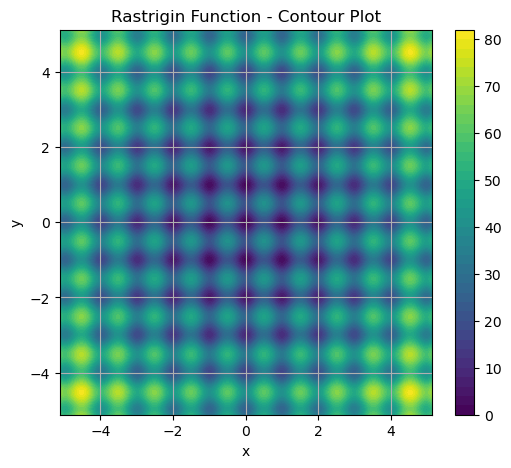

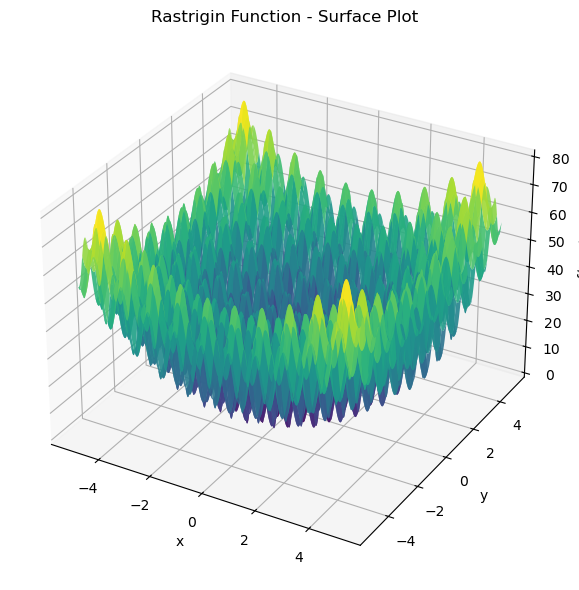

In [13]:
# Rastrigin: domain [-5.12, 5.12]
plot_function(rastrigin, [-5.12, 5.12, -5.12, 5.12], "Rastrigin Function")

### Ackley function visualization

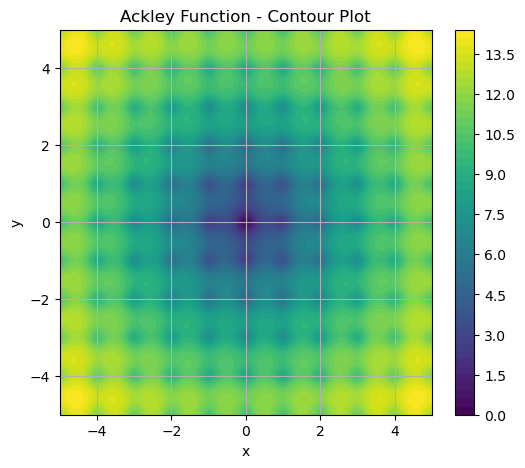

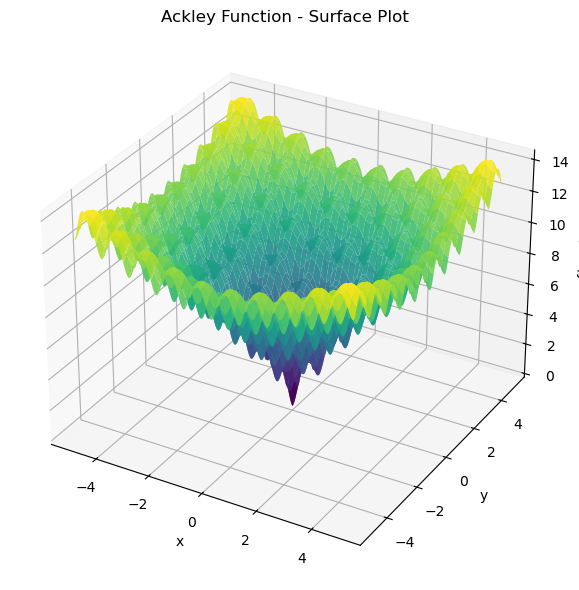

In [15]:
# Ackley: domain [-5, 5]
plot_function(ackley, [-5, 5, -5, 5], "Ackley Function")

## 3. Genetic Algorithm (GA) Optimization

The Genetic Algorithm implemented for this assignment includes the following features:

- **Representations:**
  - **Binary encoding:** Solutions are represented as binary strings.
  - **Real-valued encoding:** Solutions are represented as vectors of real numbers.

- **Crossover Operators:**
  - **Binary encoding:**
    - 1-point crossover
    - 2-point crossover
  - **Real-valued encoding:**
    - Arithmetic crossover
    - BLX-α (Blend Alpha) crossover

- **Adjustable Parameters:**
  - Mutation rate
  - Crossover rate
  - Population size
  - Number of generations

This flexible GA setup allows for experimentation with different encoding schemes, crossover methods, and parameter settings to study their effects on optimization performance.

### Imports

(Needed for the implementation of the GA)

In [18]:
import numpy as np
import random
from typing import List, Tuple, Callable

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, friedmanchisquare

import os
from datetime import datetime
from itertools import product
import warnings
warnings.filterwarnings('ignore')

### Adjustable Parameters

In this section, we define the adjustable parameters for the Genetic Algorithm (GA). These parameters control key aspects such as population size, number of generations and mutation and crossover rates. You can easily modify these values to experiment with different GA configurations.

In [20]:
# Genetic Algorithm adjustable parameters

# Population size
population_size = 50    

# Number of generations
num_generations = 100   

# Crossover rate (probability of crossover)
crossover_rate = 0.8    

# Mutation rate (probability of mutation)
mutation_rate = 0.05

### Binary Crossover and Mutation

This cell implements the genetic operators for **binary-encoded** individuals:

- **1-point crossover:** A single crossover point is randomly selected. Offspring are created by exchanging tails of the parents at this point.
- **2-point crossover:** Two crossover points are selected, and the segment between them is swapped between parents.
- **Mutation:** Each bit in the binary string has a chance (mutation rate) to flip from `0` to `1` or vice versa, introducing new genetic variation.

In [22]:
def binary_1point_crossover(parent1, parent2):
    """
    Performs one-point crossover on two binary parent strings.
    
    Parameters:
    - parent1, parent2: str
        Binary strings representing the parents.
    
    Returns:
    - tuple of two offspring binary strings produced by swapping tails after a random crossover point.
    """
    point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2


def binary_2point_crossover(parent1, parent2):
    """
    Performs two-point crossover on two binary parent strings.
    
    Parameters:
    - parent1, parent2: str
        Binary strings representing the parents.
    
    Returns:
    - tuple of two offspring binary strings created by swapping segments between two random crossover points.
    """
    point1 = random.randint(1, len(parent1) - 2)
    point2 = random.randint(point1 + 1, len(parent1) - 1)
    child1 = parent1[:point1] + parent2[point1:point2] + parent1[point2:]
    child2 = parent2[:point1] + parent1[point1:point2] + parent2[point2:]
    return child1, child2


def binary_mutation(bitstring, mutation_rate):
    """
    Applies bit-flip mutation to a binary string with a given mutation rate.
    
    Parameters:
    - bitstring: str
        The binary string to mutate.
    - mutation_rate: float
        Probability of flipping each bit.
    
    Returns:
    - A new binary string with bits mutated according to the mutation rate.
    """
    mutated = []
    for bit in bitstring:
        if random.random() < mutation_rate:
            mutated_bit = '1' if bit == '0' else '0'
        else:
            mutated_bit = bit
        mutated.append(mutated_bit)
    return ''.join(mutated)

### Real-Valued Crossover and Mutation

This cell implements genetic operators for **real-valued encoded** individuals:

- **Arithmetic crossover:** Offspring are created as weighted averages of parents using a random mixing coefficient.
- **BLX-α crossover:** For each gene, offspring are sampled uniformly from an extended interval around the parents’ gene values, controlled by parameter α.
- **Mutation:** Each gene can be mutated by replacing its value with a random value within the allowed bounds, with probability equal to the mutation rate.

In [24]:
def arithmetic_crossover(parent1, parent2):
    """
    Performs arithmetic crossover between two real-valued parents.
    
    Parameters:
    - parent1, parent2: list or array-like of floats
        Real-valued parent vectors.
    
    Returns:
    - Two offspring lists generated by weighted averaging with a random alpha coefficient.
    """
    alpha = random.random()
    child1 = [alpha * p1 + (1 - alpha) * p2 for p1, p2 in zip(parent1, parent2)]
    child2 = [alpha * p2 + (1 - alpha) * p1 for p1, p2 in zip(parent1, parent2)]
    return child1, child2


def blx_alpha_crossover(parent1, parent2, alpha=0.5):
    """
    Performs BLX-alpha crossover on two real-valued parents.
    
    Parameters:
    - parent1, parent2: list or array-like of floats
        Real-valued parent vectors.
    - alpha: float (default=0.5)
        Expansion factor controlling the sampling range beyond the parents' values.
    
    Returns:
    - Two offspring lists generated by sampling uniformly from extended intervals around parents' genes.
    """
    child1 = []
    child2 = []
    for x1, x2 in zip(parent1, parent2):
        c_min = min(x1, x2)
        c_max = max(x1, x2)
        I = c_max - c_min
        lower = c_min - alpha * I
        upper = c_max + alpha * I
        child1.append(random.uniform(lower, upper))
        child2.append(random.uniform(lower, upper))
    return child1, child2


def real_valued_mutation(individual, mutation_rate, bounds):
    """
    Applies mutation to a real-valued individual by randomly replacing genes within bounds.
    
    Parameters:
    - individual: list of floats
        Real-valued vector representing the individual.
    - mutation_rate: float
        Probability of mutating each gene.
    - bounds: list of tuples
        Bounds for each gene as (min, max).
    
    Returns:
    - A mutated individual as a list of floats.
    """
    mutated = []
    for i, gene in enumerate(individual):
        if random.random() < mutation_rate:
            low, high = bounds[i]
            mutated_gene = random.uniform(low, high)
        else:
            mutated_gene = gene
        mutated.append(mutated_gene)
    return mutated

## Population Initialization

To start the Genetic Algorithm, we need an initial population of candidate solutions.  
Since our GA supports two encoding types — binary and real-valued — we will implement separate initialization functions for each:  
- **Binary encoding**: generates random bit strings of a fixed length.  
- **Real-valued encoding**: generates random vectors within the problem domain bounds.

This initial population provides the genetic material for evolution in subsequent generations.

In [26]:
def init_population_binary(pop_size, chromosome_length):
    """
    Initialize a population of binary-encoded individuals.
    
    Parameters:
    - pop_size: number of individuals in the population
    - chromosome_length: length of each chromosome (bit string)
    
    Returns:
    - population: array of binary values with shape (pop_size, chromosome_length)
    """
    return np.random.randint(2, size=(pop_size, chromosome_length))


def init_population_real(pop_size, dim, bounds):
    """
    Initialize a population of real-valued individuals.
    
    Parameters:
    - pop_size: number of individuals in the population
    - dim: dimensionality of each individual
    - bounds: list of (min, max) bounds for each dimension
    
    Returns:
    - population: array of real values with shape (pop_size, dim)
    """
    population = np.zeros((pop_size, dim))
    for i in range(dim):
        population[:, i] = np.random.uniform(bounds[i][0], bounds[i][1], pop_size)
    return population

## Fitness Evaluation

Each individual in the population must be evaluated to determine how well it solves the optimization problem.  

The fitness function maps candidate solutions to a numerical score representing solution quality.  

For our assignment, we will use the benchmark functions (Rastrigin and Ackley) implemented earlier as fitness functions.  

This fitness evaluation guides the selection and breeding process in the GA.

In [28]:
def evaluate_fitness(population, fitness_func):
    """
    Evaluate the fitness of each individual in the population.
    population: numpy array of individuals (binary or real-valued)
    fitness_func: function that takes an individual and returns its fitness score
    Returns an array of fitness scores.
    """
    fitness_scores = np.array([fitness_func(ind) for ind in population])
    return fitness_scores

### Selection

Selection chooses individuals from the current population to become parents of the next generation. It favors fitter individuals but maintains diversity by giving weaker individuals a chance. Tournament selection works by picking a small group (tournament) of individuals randomly, then selecting the fittest among them.

In [30]:
def tournament_selection(population, fitnesses, tournament_size=3):
    """
    Perform tournament selection on the population.
    
    Parameters:
    - population: list of individuals
    - fitnesses: list of fitness values corresponding to each individual
    - tournament_size: number of individuals competing in each tournament
    
    Returns:
    - selected: individual selected from the tournament
    """
    # Convert to numpy arrays for easier indexing if not already
    fitnesses = np.array(fitnesses)
    
    # Select random indices for the tournament
    selected_indices = np.random.choice(len(population), tournament_size, replace=False)
    
    # Get tournament fitness values
    tournament_fitness = [fitnesses[i] for i in selected_indices]
    
    # Find the winner (minimization problem)
    winner_idx = selected_indices[np.argmin(tournament_fitness)]
    
    # Return a copy of the winner to avoid reference issues
    if isinstance(population[winner_idx], list):
        return population[winner_idx][:]
    else:  # string for binary encoding
        return population[winner_idx]

## Genetic Algorithm Workflow

### Core Optimization Flow
1. **Initialization Phase**
   - Creates initial population based on selected encoding scheme
   - Evaluates fitness for all initial solutions
   - Identifies current best solution

2. **Evolution Loop** (repeats until termination)
   - **Parent Selection**: Tournament selection chooses candidates for reproduction
   - **Genetic Operations**:
     - Crossover (with probability `crossover_rate`)
     - Mutation (with probability `mutation_rate`)
   - **Population Update**: New generation replaces previous population
   - **Fitness Evaluation**: Calculates fitness for new individuals
   - **Elite Preservation**: Automatically tracks best solution found

3. **Termination Conditions**
   - Reaches maximum generation count
   - Exhausts fitness evaluation budget
   - (Optional) Meets convergence criteria

### Key Design Features
- **Encoding-Aware Operations**: Automatically selects appropriate genetic operators based on encoding type
- **Resource Management**: Tracks computational budget through fitness evaluation counting
- **Adaptive Search**: Balance between exploration and exploitation controlled via:
  - Mutation/crossover rates
  - BLX-α parameter (for real-valued encoding)
  - Tournament size

### Modular Architecture
- **Interchangeable Components**:
  - Encoding schemes can be extended
  - New crossover/mutation operators can be added
  - Selection mechanisms can be modified
- **State Tracking**:
  - Maintains best solution throughout evolution
  - Optional progress reporting via verbose mode

This workflow provides a robust foundation for optimization while allowing customization through parameter tuning and component replacement. The algorithm's performance depends on appropriate parameter selection for the specific problem domain.

In [32]:
def genetic_algorithm(
    func,
    bounds,
    encoding,
    crossover_type,
    mutation_rate,
    crossover_rate,
    population_size,
    generations,
    fitness_eval_budget=5000,
    blx_alpha=0.5,
    bit_length=16,
    tournament_size=3,
    verbose=False
):
    """
    Genetic Algorithm for optimization problems.
    
    Parameters:
    - func: function to optimize (minimize)
    - bounds: list of (min, max) bounds for each dimension
    - encoding: 'binary' or 'real'
    - crossover_type: '1-point', '2-point', 'arithmetic', or 'blx-alpha'
    - mutation_rate: probability of mutation per gene
    - crossover_rate: probability of crossover
    - population_size: number of individuals in the population
    - generations: maximum number of generations
    - fitness_eval_budget: maximum number of fitness evaluations
    - blx_alpha: alpha parameter for BLX-alpha crossover (default=0.5)
    - bit_length: number of bits per dimension for binary encoding (default=16)
    - tournament_size: number of individuals in tournament selection (default=3)
    - verbose: whether to print progress information (default=False)
    
    Returns:
    - best_individual: best solution found
    - best_fitness: fitness of the best solution
    """
    dim = len(bounds)

    # Initialize population using our functions
    if encoding == 'real':
        population = init_population_real(population_size, dim, bounds)
        # Convert numpy array to list of lists for compatibility with crossover functions
        population = [list(ind) for ind in population]
    else:  # binary encoding
        total_bits = dim * bit_length
        # Initialize as binary strings
        population = [''.join(str(bit) for bit in ind) 
                    for ind in init_population_binary(population_size, total_bits)]

    # Fitness evaluation using our function
    if encoding == 'real':
        fitnesses = [func(ind) for ind in population]
    else:  # binary encoding
        fitnesses = [func(decode_binary(ind, bounds, bit_length)) for ind in population]
    fitness_evals = population_size

    # Track best
    best_idx = np.argmin(fitnesses)
    best_individual = population[best_idx]
    best_fitness = fitnesses[best_idx]

    gen = 0
    while gen < generations and fitness_evals < fitness_eval_budget:
        gen += 1
        new_population = []

        while len(new_population) < population_size:
            # Selection using tournament selection
            parent1 = tournament_selection(population, fitnesses, tournament_size)
            parent2 = tournament_selection(population, fitnesses, tournament_size)

            # Crossover
            if random.random() < crossover_rate:
                if encoding == 'real':
                    if crossover_type == 'arithmetic':
                        child1, child2 = arithmetic_crossover(parent1, parent2)
                    elif crossover_type == 'blx-alpha':
                        child1, child2 = blx_alpha_crossover(parent1, parent2, alpha=blx_alpha)
                    else:
                        raise ValueError(f"Unknown real crossover type: {crossover_type}")
                else:  # binary
                    if crossover_type == '1-point':
                        child1, child2 = binary_1point_crossover(parent1, parent2)
                    elif crossover_type == '2-point':
                        child1, child2 = binary_2point_crossover(parent1, parent2)
                    else:
                        raise ValueError(f"Unknown binary crossover type: {crossover_type}")
            else:
                child1, child2 = parent1[:], parent2[:]  # Use copies to avoid reference issues

            # Mutation
            if encoding == 'real':
                child1 = real_valued_mutation(child1, mutation_rate, bounds)
                child2 = real_valued_mutation(child2, mutation_rate, bounds)
            else:  # binary
                child1 = binary_mutation(child1, mutation_rate)
                child2 = binary_mutation(child2, mutation_rate)

            new_population.extend([child1, child2])

        # Trim population if exceeded
        population = new_population[:population_size]

        # Evaluate fitness again
        if encoding == 'real':
            fitnesses = [func(ind) for ind in population]
        else:  # binary encoding
            fitnesses = [func(decode_binary(ind, bounds, bit_length)) for ind in population]
        fitness_evals += population_size

        # Update best
        current_best_idx = np.argmin(fitnesses)
        current_best_fitness = fitnesses[current_best_idx]
        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            best_individual = population[current_best_idx]

        if verbose and gen % 10 == 0:  # Print every 10 generations to reduce output
            print(f"Gen {gen}: Best Fitness = {best_fitness:.5f}, Fitness Evals = {fitness_evals}")

    # Decode if binary
    if encoding == 'binary':
        best_individual = decode_binary(best_individual, bounds, bit_length)

    return best_individual, best_fitness


# Helper function to help decode
def decode_binary(bitstring, bounds, bit_length):
    """
    Decode a binary string to a real-valued vector.
    
    Parameters:
    - bitstring: binary string
    - bounds: list of (min, max) bounds for each dimension
    - bit_length: number of bits per dimension
    
    Returns:
    - decoded: real-valued vector
    """
    dim = len(bounds)
    decoded = []
    for i in range(dim):
        start = i * bit_length
        end = start + bit_length
        bits = bitstring[start:end]
        integer = int(bits, 2)
        low, high = bounds[i]
        val = low + (integer / (2**bit_length - 1)) * (high - low)
        decoded.append(val)
    return decoded

## 4. Optimization Experiments

### Experiment Execution System

#### Core Components

##### Single Experiment Runner (`run_experiment`)
- **Purpose**: Executes one complete GA run with specified configuration
- **Input Handling**: Unpacks experiment parameters from argument tuple
- **Parameter Management**: Extracts GA settings with fallback defaults
- **Execution Flow**:
  1. Configures GA with given parameters
  2. Runs optimization process
  3. Captures best solution and fitness
- **Output**: Structured dictionary containing:
  - Function name
  - Encoding scheme
  - Crossover type
  - Run identifier
  - Optimization results

##### Batch Experiment Manager (`run_all_experiments`)
- **Purpose**: Coordinates comprehensive testing across multiple configurations
- **Default Parameters**: Provides standard GA settings if none specified
- **Configuration Setup**:
  - Defines encoding/crossover combinations
  - Sets benchmark functions with dimensional bounds
- **Experiment Design**:
  - Creates full factorial design (functions × configs × runs)
  - Tracks total experiment count
- **Progress Monitoring**: Outputs completion status during execution
- **Result Processing**:
  - Aggregates individual run results
  - Computes summary statistics (min, mean, std, median)
  - Formats output for analysis

#### Key Features

- **Systematic Testing**: Evaluates all combinations of:
  - Benchmark functions (Rastrigin, Ackley)
  - Encoding schemes (real, binary)
  - Crossover methods (4 variants)
- **Statistical Rigor**: Performs multiple runs (default: 30) per configuration
- **Progress Tracking**: Real-time console updates during execution
- **Structured Output**: Returns both raw data and summary statistics
- **Flexible Configuration**: Allows parameter customization while providing sensible defaults

#### Output Structure

**Raw Results DataFrame**:
- Contains detailed records of every experiment run
- Preserves individual run characteristics and outcomes

**Summary DataFrame**:
- Grouped by function, encoding, and crossover type
- Provides key performance metrics:
  - Best fitness found
  - Average performance
  - Variability measures
  - Median values

#### Usage Pattern

1. Configure experiment parameters (optional)
2. Execute full test suite
3. Analyze returned dataframes:
   - Raw data for detailed examination
   - Summary statistics for comparative analysis
4. Results automatically printed in readable format

The framework enables rigorous, reproducible comparison of GA variations while handling the complexities of large-scale experimentation.

In [34]:
def run_experiment(args):
    """
    Run a single experiment with the given parameters.
    
    Parameters:
    - args: tuple containing (func, bounds, config, run_id)
    
    Returns:
    - dict with experiment results
    """
    func, bounds, config, func_name, run_id, params = args
    
    # Extract parameters
    mutation_rate = params.get('mutation_rate', 0.05)
    crossover_rate = params.get('crossover_rate', 0.8)
    population_size = params.get('population_size', 50)
    num_generations = params.get('num_generations', 100)
    fitness_eval_budget = params.get('fitness_eval_budget', 5000)
    
    # Run genetic algorithm
    best_individual, best_fitness = genetic_algorithm(
        func=func,
        bounds=bounds,
        encoding=config['encoding'],
        crossover_type=config['crossover_type'],
        mutation_rate=mutation_rate,
        crossover_rate=crossover_rate,
        population_size=population_size,
        generations=num_generations,
        fitness_eval_budget=fitness_eval_budget,
        verbose=False
    )
    
    # Return results
    return {
        "Function": func_name,
        "Encoding": config['encoding'],
        "Crossover": config['crossover_type'],
        "Run": run_id,
        "BestFitness": best_fitness,
        "BestSolution": best_individual,
    }

def run_all_experiments(params=None):
    """
    Run experiments sequentially for all combinations of functions and configurations.
    
    Parameters:
    - params: dictionary of parameters for the genetic algorithm
    
    Returns:
    - DataFrame with experiment results
    """
    if params is None:
        params = {
            'mutation_rate': 0.05,
            'crossover_rate': 0.8,
            'population_size': 50,
            'num_generations': 100,
            'fitness_eval_budget': 5000,
            'num_runs': 30,
            'dim': 10
        }
    
    print(f"Starting experiments with parameters: {params}")
    print(f"Dimensionality: {params['dim']}, Fitness Evaluation Budget: {params['fitness_eval_budget']}")
    
    # Configuration settings
    configs = [
        # Real-valued encoding
        {'encoding': 'real', 'crossover_type': 'arithmetic'},
        {'encoding': 'real', 'crossover_type': 'blx-alpha'},
        # Binary encoding
        {'encoding': 'binary', 'crossover_type': '1-point'},
        {'encoding': 'binary', 'crossover_type': '2-point'},
    ]
    
    # Function definitions
    dim = params['dim']
    benchmark_funcs = {
        "rastrigin": (rastrigin, [(-5.12, 5.12)] * dim),
        "ackley": (ackley, [(-5, 5)] * dim),
    }
    
    # Prepare experiment arguments
    experiment_args = []
    for func_name, (func, bounds) in benchmark_funcs.items():
        for config in configs:
            for run_id in range(params['num_runs']):
                experiment_args.append((func, bounds, config, func_name, run_id, params))
    
    # Run experiments sequentially instead of in parallel
    print(f"Running {len(experiment_args)} experiments sequentially...")
    results = []
    total_experiments = len(experiment_args)
    
    for i, args in enumerate(experiment_args):
        # Print progress
        if (i+1) % 10 == 0 or i == 0 or i == total_experiments-1:
            print(f"Progress: {i+1}/{total_experiments} experiments completed")
        
        # Run single experiment
        result = run_experiment(args)
        results.append(result)
    
    # Convert results to DataFrame
    df = pd.DataFrame(results)
    
    # Calculate summary statistics
    summary_df = df.groupby(['Function', 'Encoding', 'Crossover']).agg({
        'BestFitness': ['min', 'mean', 'std', 'median']
    }).reset_index()
    
    # Flatten the MultiIndex columns
    summary_df.columns = ['_'.join(col).strip('_') for col in summary_df.columns.values]
    summary_df.rename(columns={
        'BestFitness_min': 'Best',
        'BestFitness_mean': 'Mean',
        'BestFitness_std': 'Std',
        'BestFitness_median': 'Median'
    }, inplace=True)
    
    # Print summary results
    print("\nExperiment Results Summary:")
    for _, row in summary_df.iterrows():
        print(f"[✓] {row['Function']} | {row['Encoding']} | {row['Crossover']} → "
              f"Best: {row['Best']:.4f}, Mean: {row['Mean']:.4f}, Std: {row['Std']:.4f}")
    
    return df, summary_df

## 5. Statistical Analysis

### Overview
This module performs comprehensive statistical comparisons between different genetic algorithm configurations, providing quantitative evidence for performance differences.

### Analysis Framework

#### Core Comparisons
1. **Encoding Schemes**
   - Real-valued vs Binary encoding performance
   - Uses both parametric and non-parametric tests

2. **Crossover Methods**
   - Pairwise comparison within each encoding type
   - Tests all implemented crossover variants

#### Statistical Tests
- **Parametric**: Independent t-test (Welch's variant)
  - Accounts for unequal variances
  - Assumes normal distribution
  
- **Non-parametric**: Mann-Whitney U test
  - Makes no distributional assumptions
  - Robust to outliers

#### Analysis Workflow
1. **Data Preparation**
   - Filters results by benchmark function
   - Groups by encoding scheme and crossover type

2. **Hypothesis Testing**
   - Performs parallel parametric/non-parametric tests
   - Records test statistics and p-values
   - Determines significance (α=0.05)

3. **Result Formatting**
   - Structures output for readability
   - Provides clear significance labeling

### Key Features

#### Comprehensive Testing
- Automatic comparison of all configuration pairs
- Handles both encoding and crossover variations
- Processes multiple benchmark functions

#### Robust Methodology
- Dual-test approach validates findings
- Conservative variance handling (Welch's t-test)
- Two-tailed alternative hypotheses

#### Clear Reporting
- Standardized output format
- Plain-language significance indicators
- Complete test statistics preservation

### Output Structure
Returns a DataFrame containing:
- Benchmark function name
- Comparison description
- Test type (T-test/Mann-Whitney U)
- Test statistic value
- Computed p-value
- Significance determination

### Interpretation Guidance
- **Significant results** indicate performance differences are unlikely due to chance
- **Consistent findings** across both tests strengthen conclusions
- **Effect size** should be considered alongside significance

The module enables rigorous, quantitative comparison of genetic algorithm variations, supporting data-driven optimization decisions.

In [36]:
def statistical_analysis(results_df):
    """
    Perform statistical analysis on the experiment results.
    
    Parameters:
    - results_df: DataFrame with experiment results
    
    Returns:
    - DataFrame with statistical test results
    """
    print("\nPerforming Statistical Analysis...")
    
    # Create a dictionary to store test results
    test_results = []
    
    # For each function, compare different configurations
    for func_name in results_df['Function'].unique():
        func_df = results_df[results_df['Function'] == func_name]
        
        # Compare encoding types (real vs binary)
        real_vals = func_df[func_df['Encoding'] == 'real']['BestFitness'].values
        bin_vals = func_df[func_df['Encoding'] == 'binary']['BestFitness'].values
        
        # T-test for normally distributed data
        t_stat, t_pval = ttest_ind(real_vals, bin_vals, equal_var=False)
        
        # Mann-Whitney U test for non-parametric comparison
        u_stat, u_pval = mannwhitneyu(real_vals, bin_vals, alternative='two-sided')
        
        test_results.append({
            'Function': func_name,
            'Comparison': 'Real vs Binary',
            'Test': 'T-test',
            'Statistic': t_stat,
            'P-value': t_pval,
            'Significant': t_pval < 0.05
        })
        
        test_results.append({
            'Function': func_name,
            'Comparison': 'Real vs Binary',
            'Test': 'Mann-Whitney U',
            'Statistic': u_stat,
            'P-value': u_pval,
            'Significant': u_pval < 0.05
        })
        
        # Compare crossover types for real encoding
        for encoding in ['real', 'binary']:
            encoding_df = func_df[func_df['Encoding'] == encoding]
            crossover_types = encoding_df['Crossover'].unique()
            
            if len(crossover_types) > 1:
                cross1_vals = encoding_df[encoding_df['Crossover'] == crossover_types[0]]['BestFitness'].values
                cross2_vals = encoding_df[encoding_df['Crossover'] == crossover_types[1]]['BestFitness'].values
                
                # T-test
                t_stat, t_pval = ttest_ind(cross1_vals, cross2_vals, equal_var=False)
                
                # Mann-Whitney U test
                u_stat, u_pval = mannwhitneyu(cross1_vals, cross2_vals, alternative='two-sided')
                
                test_results.append({
                    'Function': func_name,
                    'Comparison': f'{crossover_types[0]} vs {crossover_types[1]} ({encoding})',
                    'Test': 'T-test',
                    'Statistic': t_stat,
                    'P-value': t_pval,
                    'Significant': t_pval < 0.05
                })
                
                test_results.append({
                    'Function': func_name,
                    'Comparison': f'{crossover_types[0]} vs {crossover_types[1]} ({encoding})',
                    'Test': 'Mann-Whitney U',
                    'Statistic': u_stat,
                    'P-value': u_pval,
                    'Significant': u_pval < 0.05
                })
    
    # Convert to DataFrame
    test_df = pd.DataFrame(test_results)
    
    # Print test results
    print("\nStatistical Test Results:")
    for _, row in test_df.iterrows():
        sig = "Significant" if row['Significant'] else "Not Significant"
        print(f"{row['Function']} | {row['Comparison']} | {row['Test']}: "
              f"p-value = {row['P-value']:.4f} ({sig})")
    
    return test_df

### Genetic Algorithm Visualization Module

#### Overview
This module creates comparative visualizations of genetic algorithm performance across different configurations. It generates two types of plots for each benchmark function: distribution boxplots and mean performance bar charts.

#### Visualization Types

##### 1. Fitness Distribution Boxplots
- Displays the spread of fitness values across all runs
- Shows comparisons between:
  - Different encoding schemes (real vs binary)
  - Different crossover methods
- Visual elements:
  - Boxes show interquartile range (IQR)
  - Whiskers extend to 1.5*IQR
  - Median line shown within each box
  - Outliers excluded for cleaner visualization

##### 2. Mean Performance Bar Charts
- Illustrates average performance with variability indicators
- Compares:
  - Central tendency (mean fitness) across configurations
  - Performance variability (standard deviation error bars)
- Organized by:
  - Crossover method on x-axis
  - Encoding scheme differentiated by color

#### Implementation Details

##### Data Handling
- Accepts two DataFrames:
  - `results_df`: Raw experimental results
  - `summary_df`: Pre-computed statistics
- Automatically processes data for each benchmark function
- Uses pivot tables to reorganize data for plotting

##### Plot Configuration
- Consistent styling using Seaborn's "whitegrid"
- Standardized figure size (12x8 inches)
- Clear labeling:
  - Descriptive titles
  - Axis labels with units
  - Legend for encoding schemes
- Proper spacing with tight_layout()

##### Display Options
- Plots shown inline in notebook/IDE
- Sequential display of all visualizations
- Automatic cleanup of figure objects after display

#### Usage Example

The module will automatically:
1. Generate and display boxplots for each function
2. Create and show bar charts of mean performance
3. Print completion message when done

#### Output Interpretation
- **Lower fitness values** indicate better performance
- **Smaller boxes/error bars** suggest more consistent results
- **Non-overlapping distributions** may indicate significant differences
- Compare both visualization types for comprehensive analysis

In [66]:
def create_visualizations(results_df, summary_df):
    """
    Create and display visualizations of the experiment results.
    
    Parameters:
    - results_df: DataFrame with raw experiment results
    - summary_df: DataFrame with summary statistics
    """
    # Set style for plots
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (12, 8)
    
    # 1. Boxplot of fitness by configuration for each function
    for func_name in results_df['Function'].unique():
        plt.figure()
        func_data = results_df[results_df['Function'] == func_name]
        
        ax = sns.boxplot(
            x='Crossover', 
            y='BestFitness', 
            hue='Encoding', 
            data=func_data,
            showfliers=False
        )
        
        plt.title(f"{func_name.capitalize()} Function: Fitness Distribution", fontsize=14)
        plt.ylabel("Fitness (Lower is Better)", fontsize=12)
        plt.xlabel("Crossover Type", fontsize=12)
        plt.legend(title="Encoding")
        plt.tight_layout()
        plt.show()
        plt.close()
    
    # 2. Bar plot of mean fitness with error bars
    for func_name in summary_df['Function'].unique():
        plt.figure()
        func_data = summary_df[summary_df['Function'] == func_name]
        
        # Pivot the data for easier plotting
        pivot_df = func_data.pivot(index='Crossover', columns='Encoding', values='Mean')
        std_df = func_data.pivot(index='Crossover', columns='Encoding', values='Std')
        
        # Get crossover types and encoding types
        crossover_types = pivot_df.index.tolist()
        encoding_types = pivot_df.columns.tolist()
        
        # Set up plot positions
        positions = np.arange(len(crossover_types))
        width = 0.35
        
        # Plot bars for each encoding type
        for j, encoding in enumerate(encoding_types):
            plt.bar(
                positions + (j - 0.5) * width,
                pivot_df[encoding],
                width,
                label=encoding,
                yerr=std_df[encoding],
                capsize=5
            )
        
        plt.xticks(positions, crossover_types)
        plt.title(f"{func_name.capitalize()} Function: Mean Fitness", fontsize=14)
        plt.ylabel("Mean Fitness (Lower is Better)", fontsize=12)
        plt.xlabel("Crossover Type", fontsize=12)
        plt.legend(title="Encoding")
        plt.tight_layout()
        plt.show()
        plt.close()
    
    print("All visualizations displayed")

## Genetic Algorithm Experiment Pipeline

### Overview
This function orchestrates the complete experimental workflow for evaluating genetic algorithm performance across different configurations. It handles the end-to-end process from running experiments to generating final results.

### Workflow Steps

1. **Experiment Execution**
   - Runs multiple GA configurations using `run_all_experiments()`
   - Handles parameter initialization with defaults if none provided
   - Manages parallel execution of independent runs

2. **Statistical Analysis**
   - Performs comparative tests between different configurations
   - Includes both parametric (t-test) and non-parametric (Mann-Whitney U) tests
   - Tests encoding schemes and crossover methods separately

3. **Results Visualization**
   - Generates two complementary plot types:
     - Distribution boxplots showing performance variability
     - Mean performance bar charts with error indicators

4. **Output Generation**
   - Returns three structured DataFrames containing:
     - Raw experimental results
     - Summary statistics
     - Statistical test outcomes

### Key Features

- **Parameter Flexibility**: Accepts custom GA parameters or uses sensible defaults
- **Reproducible Results**: Timestamp-based organization of output files
- **Comprehensive Analysis**: Combines numerical and visual results
- **Modular Design**: Easy to extend or modify individual components

Starting experiments with parameters: {'mutation_rate': 0.05, 'crossover_rate': 0.8, 'population_size': 50, 'num_generations': 100, 'fitness_eval_budget': 5000, 'num_runs': 30, 'dim': 10}
Dimensionality: 10, Fitness Evaluation Budget: 5000
Running 240 experiments sequentially...
Progress: 1/240 experiments completed
Progress: 10/240 experiments completed
Progress: 20/240 experiments completed
Progress: 30/240 experiments completed
Progress: 40/240 experiments completed
Progress: 50/240 experiments completed
Progress: 60/240 experiments completed
Progress: 70/240 experiments completed
Progress: 80/240 experiments completed
Progress: 90/240 experiments completed
Progress: 100/240 experiments completed
Progress: 110/240 experiments completed
Progress: 120/240 experiments completed
Progress: 130/240 experiments completed
Progress: 140/240 experiments completed
Progress: 150/240 experiments completed
Progress: 160/240 experiments completed
Progress: 170/240 experiments completed
Progress: 1

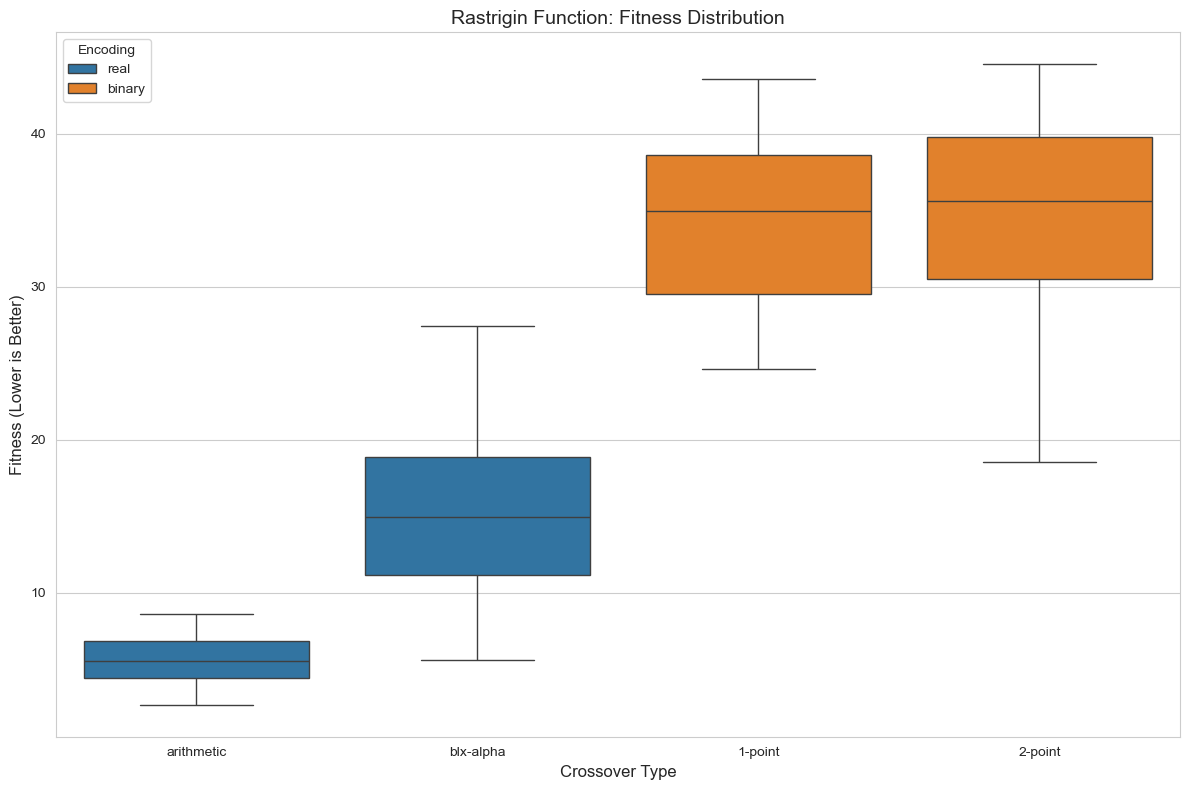

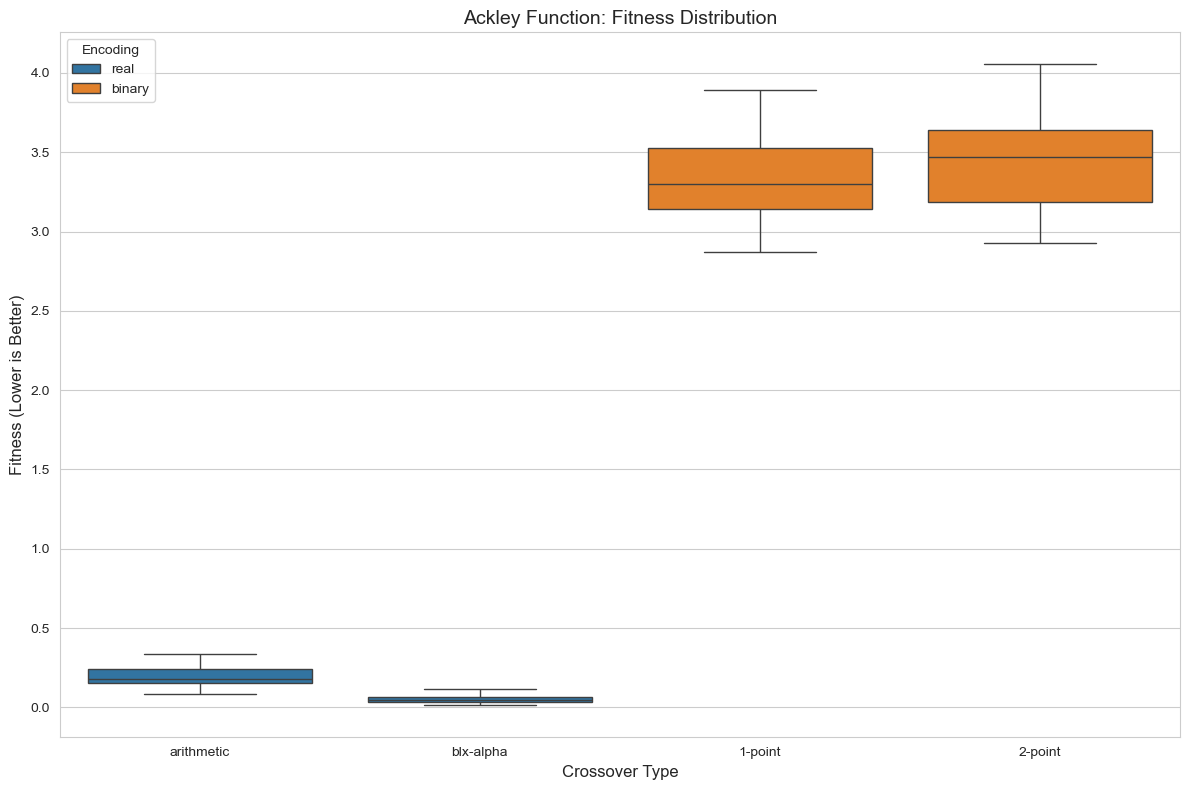

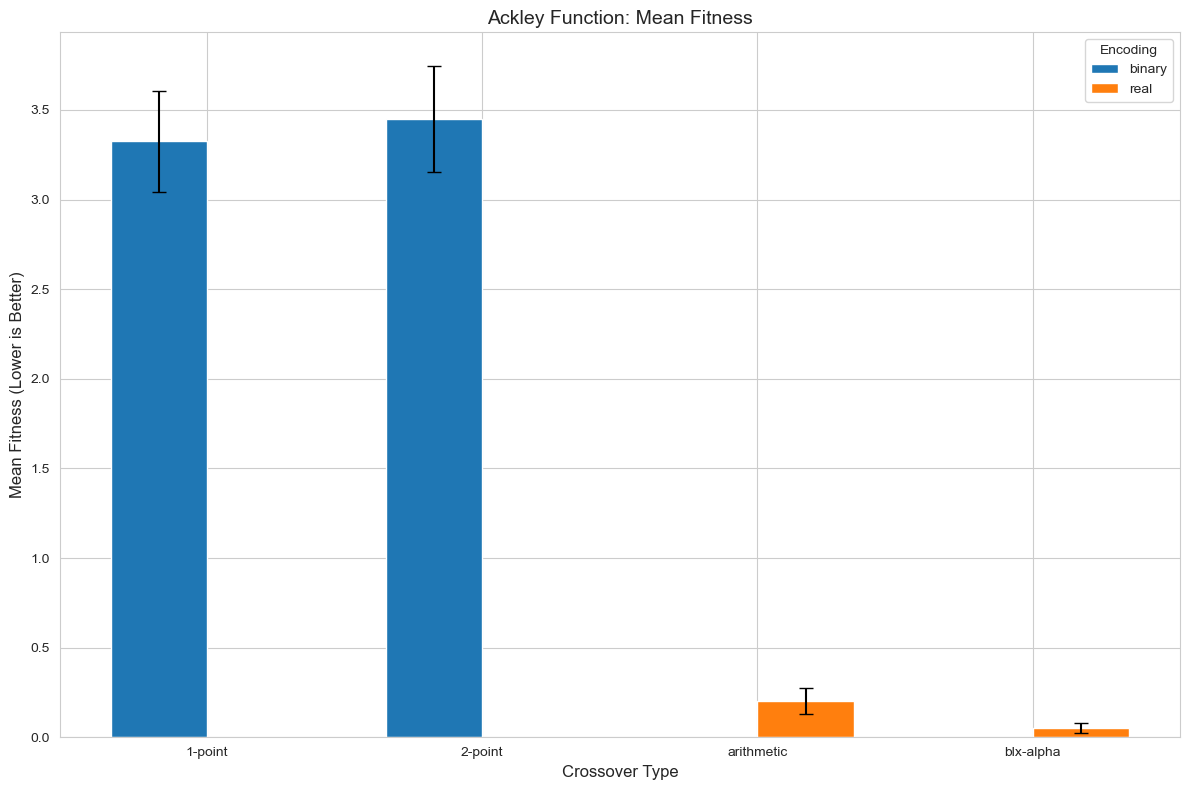

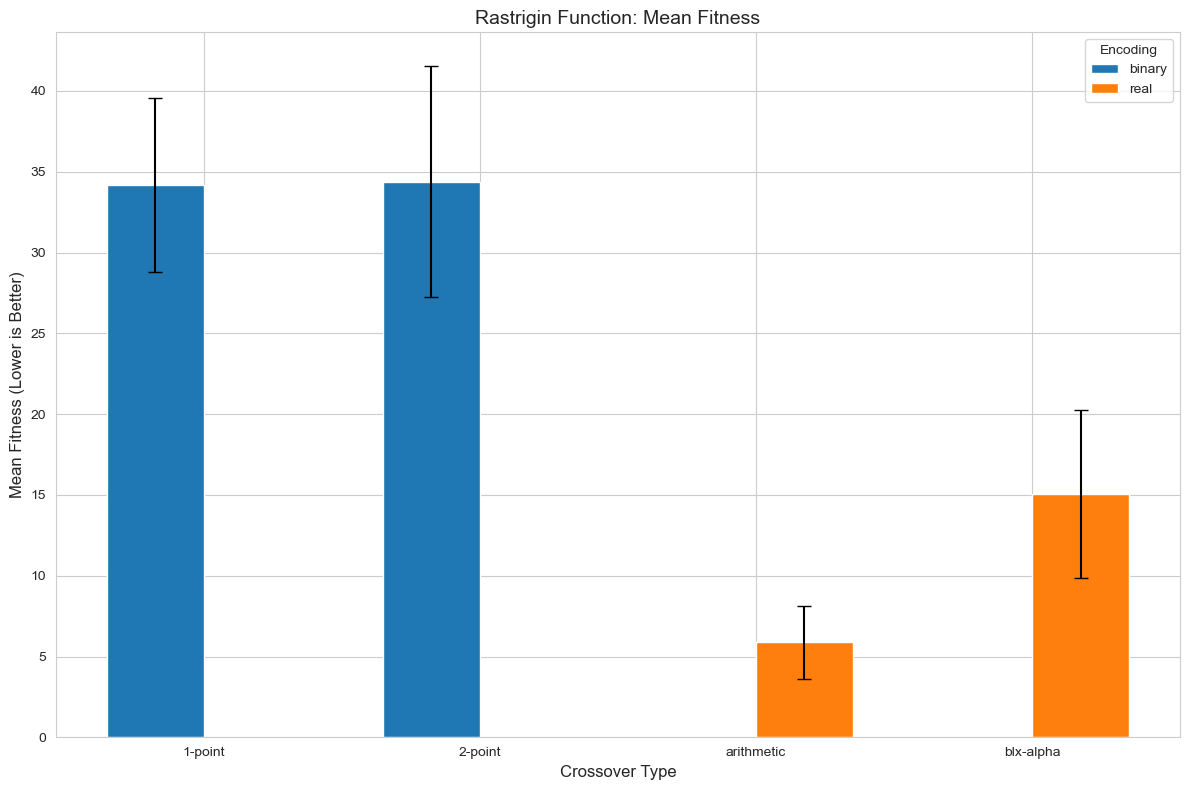

All visualizations displayed

Done!


In [70]:
def run_and_analyze(params=None):
    """
    Run experiments, perform statistical analysis, and create visualizations.
    
    Parameters:
    - params: dictionary of parameters for the genetic algorithm
    
    Returns:
    - results_df: DataFrame with raw experiment results
    - summary_df: DataFrame with summary statistics
    - test_df: DataFrame with statistical test results
    """
    # Get current timestamp for saving files
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Run experiments
    results_df, summary_df = run_all_experiments(params)
    
    # Perform statistical tests
    test_df = statistical_analysis(results_df)

    # Create visualizations
    create_visualizations(results_df, summary_df)
    
    return results_df, summary_df, test_df

if __name__ == "__main__":
    # Define parameters for the experiments
    params = {
        'mutation_rate': mutation_rate,
        'crossover_rate': crossover_rate,
        'population_size': population_size,
        'num_generations': num_generations,
        'fitness_eval_budget': 5000,
        'num_runs': 30,
        'dim': 10
    }
    
    # Run experiments and analysis
    results_df, summary_df, test_df = run_and_analyze(params)
    
    print("\nDone!")

## Reference

[1] Surjanovic, S. & Bingham, D. (2013). Virtual Library of Simulation Experiments: Test Functions and Datasets. Retrieved May 13, 2025, from http://www.sfu.ca/~ssurjano